## Indoor Positioning System (IPS) - R-code
#### Nicole Wittlin, Steven Hayden, Joseph Schueder, Kevin Mendonsa


### Understanding and processing the data collected

In [1]:
#set path to the file, the data file should be in the folder as a script
#setwd("C:/Users/kevinm/Documents/SMU/MSDS7333_QuantifyingTheWorld/Week1")
options(digits = 2)
library(lattice)

offlineRAW = readLines("offline.final.trace.txt")

Warning message:
"package 'lattice' was built under R version 3.6.3"

In [2]:
# Create a function to process the data by line/row/record
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  if (length(tokens) == 10) # if length equql=10 then NULL - eliminates warnings in "R"
    return(NULL)
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
               byrow = TRUE), tmp)
}

# exclude rows starting with "#"
lines = offlineRAW[ substr(offlineRAW, 1, 1) != "#" ]

tmp = lapply(lines, processLine)
offlineStage = as.data.frame(do.call("rbind", tmp), 
                        stringsAsFactors = FALSE)

# Cleaning the Data and Building a Representation for EDA
# Rename the fields with meaningful names
names(offlineStage) = c("time", "scanMac", "posX", "posY", "posZ", 
                   "orientation", "mac", "signal", 
                   "channel", "type")

# we convert the position, signal, and time variables to numeric
numVars = c("time", "posX", "posY", "posZ", 
            "orientation", "signal")
offlineStage[ numVars ] =  lapply(offlineStage[ numVars ], as.numeric)

# filter adhoc measurement records and drop the type variable 
offlineStage = offlineStage[ offlineStage$type == "3", ]
offlineStage = offlineStage[ , "type" != names(offlineStage) ]

# convert time to POSIX class
offlineStage$rawTime = offlineStage$time
offlineStage$time = offlineStage$time/1000
class(offlineStage$time) = c("POSIXt", "POSIXct")

# verify that variables
print('The classes of the variables in the offline data set are...')
unlist(lapply(offlineStage, class))

[1] "The classes of the variables in the offline data set are..."


time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

In [3]:
# review summary stats for numeric variables
print('The summary basic fit statistics for the variables in the offline data set are...')
summary(offlineStage[, numVars])

[1] "The summary basic fit statistics for the variables in the offline data set are..."


      time                          posX         posY           posZ  
 Min.   :2006-02-10 23:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 05:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 11:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 06:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 06:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 12:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

In [4]:
# convert character variables to factors and examine with summary
print('The MAC addresses and channels in the data set are...')
summary(sapply(offlineStage[ , c("mac", "channel", "scanMac")],
               as.factor))
# drop variables scanMac and posZ
offlineStage = offlineStage[ , !(names(offlineStage) %in% c("scanMac", "posZ"))]

[1] "The MAC addresses and channels in the data set are..."


                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

### Exploratory Data Analysis (EDA)

[1] "We can see from the plot that the measurements of angles are not exactly at 45degree intervals. Therefore we need to round the orientations to the nearest 45degree angle for further analysis."


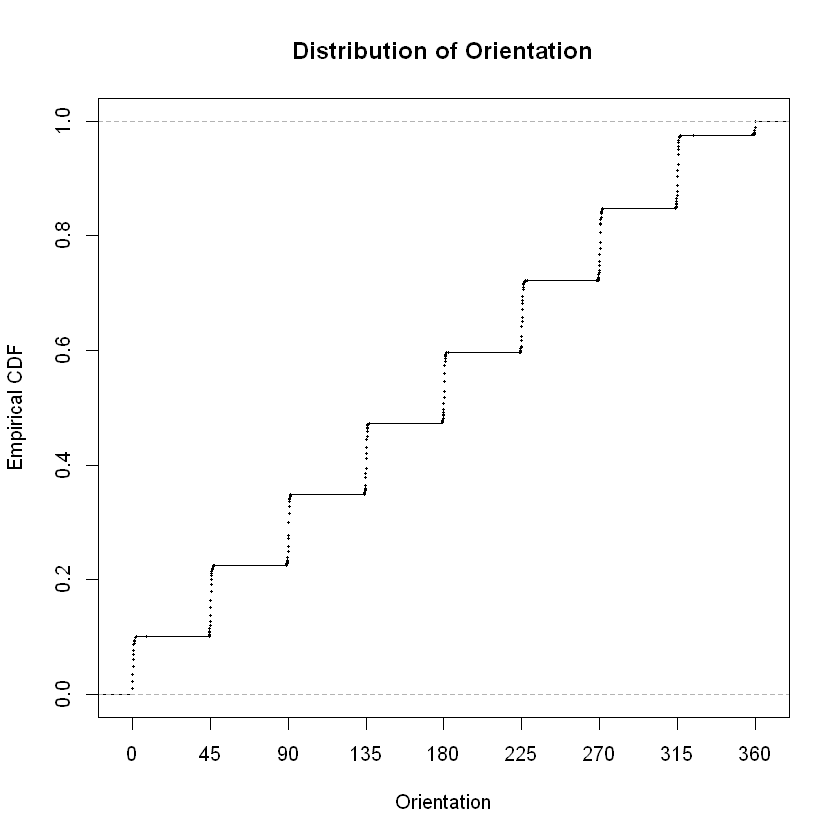

In [5]:
# Plot the distribution of orientation
plot(ecdf(offlineStage$orientation), pch = 19, cex = 0.3,
     xlim = c(-5, 365), axes = FALSE,
     xlab = "Orientation", ylab = "Empirical CDF", main = "Distribution of Orientation")
box()
axis(2)
axis(side = 1, at = seq(0, 360, by = 45))

print('We can see from the plot that the measurements of angles are not exactly at 45degree intervals. Therefore we need to round the orientations to the nearest 45degree angle for further analysis.')

[1] "It is evident that the number of measurements at each approximate angle are similar.  Angle 0 and 360 need to be combined to a single category"


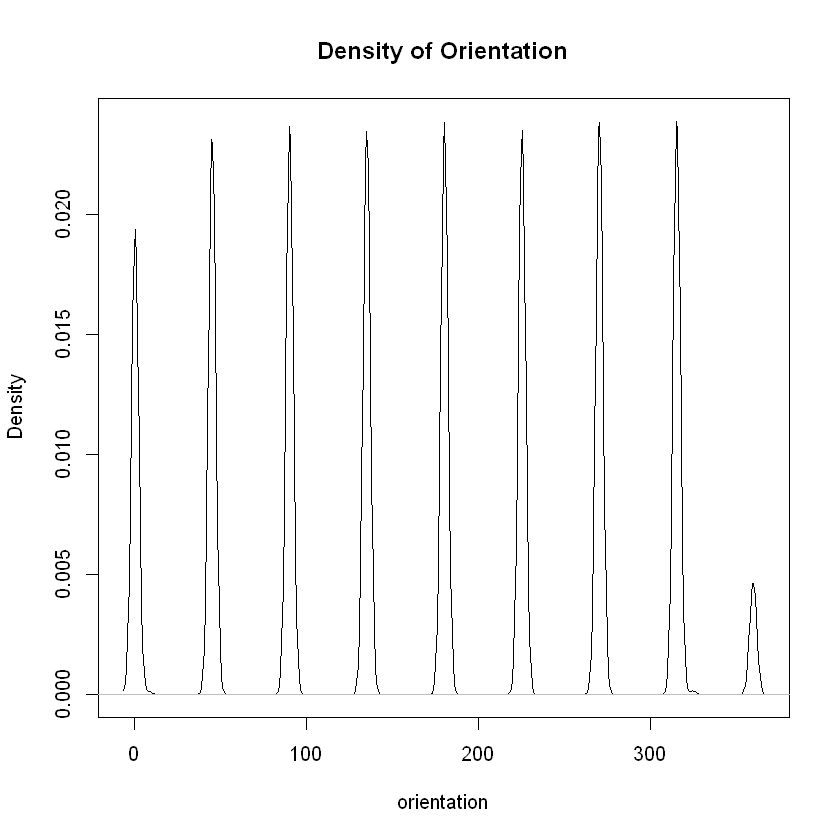

In [6]:
# Plot the density of orientation:
plot(density(offlineStage$orientation, bw = 2), 
     xlab = "orientation", main = "Density of Orientation")

print('It is evident that the number of measurements at each approximate angle are similar.  Angle 0 and 360 need to be combined to a single category')

[1] "After rounding the angles and assigning them to the nearest 45degree they are normally distributed"


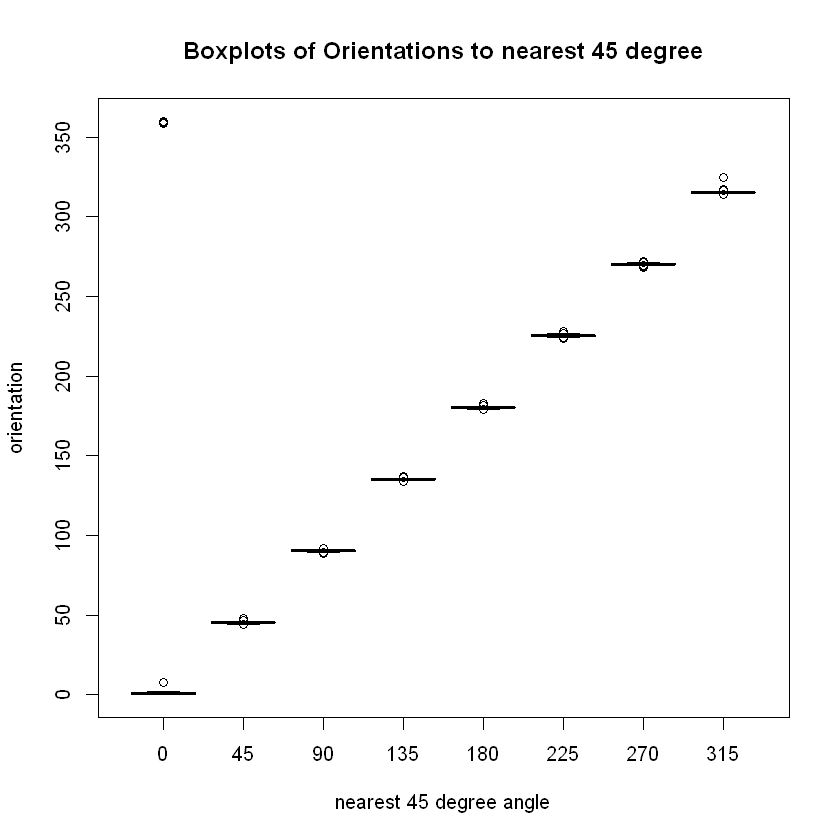

In [7]:
# Map orientations to 8 equi-spaced angles 360/8 = 45 degrees 
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

# Round the angles using roundOrientation()
offlineStage$angle = roundOrientation(offlineStage$orientation)

with(offlineStage, boxplot(orientation ~ angle,
                      main = "Boxplots of Orientations to nearest 45 degree",
                      xlab = "nearest 45 degree angle",
                      ylab = "orientation"))
print('After rounding the angles and assigning them to the nearest 45degree they are normally distributed')

In [8]:
# Exploring MAC Addresses
subMacs = names(sort(table(offlineStage$mac), decreasing = TRUE))[1:7]
offlineStage = offlineStage[ offlineStage$mac %in% subMacs, ]

macChannel = with(offlineStage, table(mac, channel))
print('MAC addresses in offline data set')
apply(macChannel, 1, function(x) sum(x > 0))
offline = offlineStage[ , "channel" != names(offlineStage)]

# Exploring the Position of the Hand-Held Device
locDF = with(offlineStage,
             by(offlineStage, list(posX, posY), function(x) x))

# drop these unneeded elements
locDF = locDF[ !sapply(locDF, is.null) ]
locCounts = sapply(locDF, nrow)
locCounts = sapply(locDF,
                   function(df)
                     c(df[1, c("posX", "posY")], count = nrow(df)))

[1] "MAC addresses in offline data set"


00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

[1] "The plot below represents a count of signals detected at every position mapped"


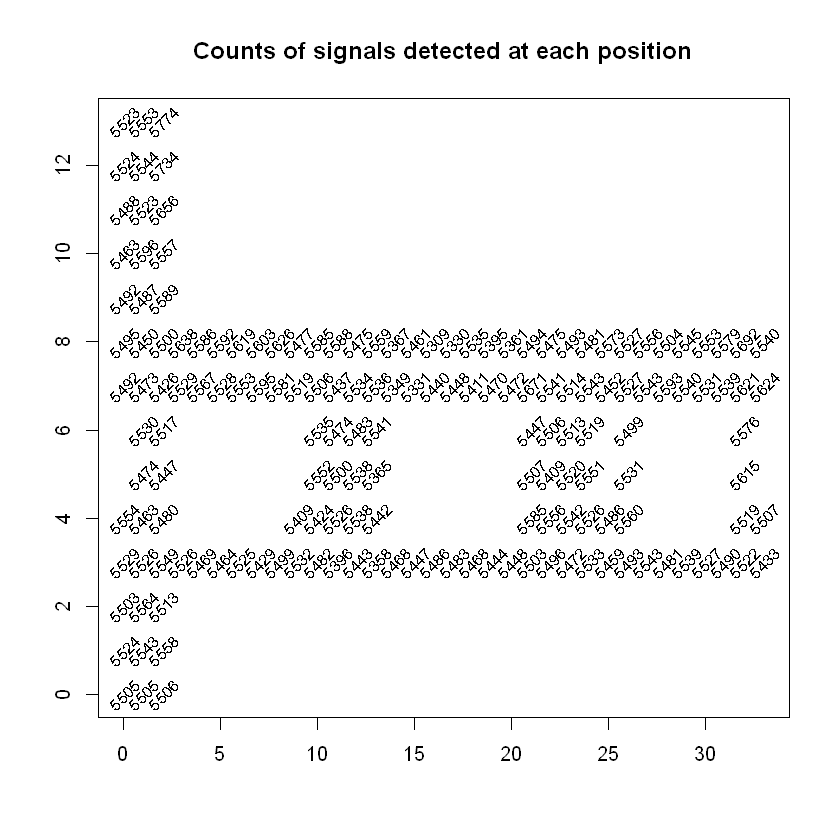

In [9]:
#class(locCounts)
#dim(locCounts)
#locCounts[ , 1:8]
print('The plot below represents a count of signals detected at every position mapped')

locCounts = t(locCounts)
plot(locCounts, type = "n", 
                main = "Counts of signals detected at each position",
                xlab = "", 
                ylab = "")
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

[1] "Below is a distribution of signals by angle for every access point"


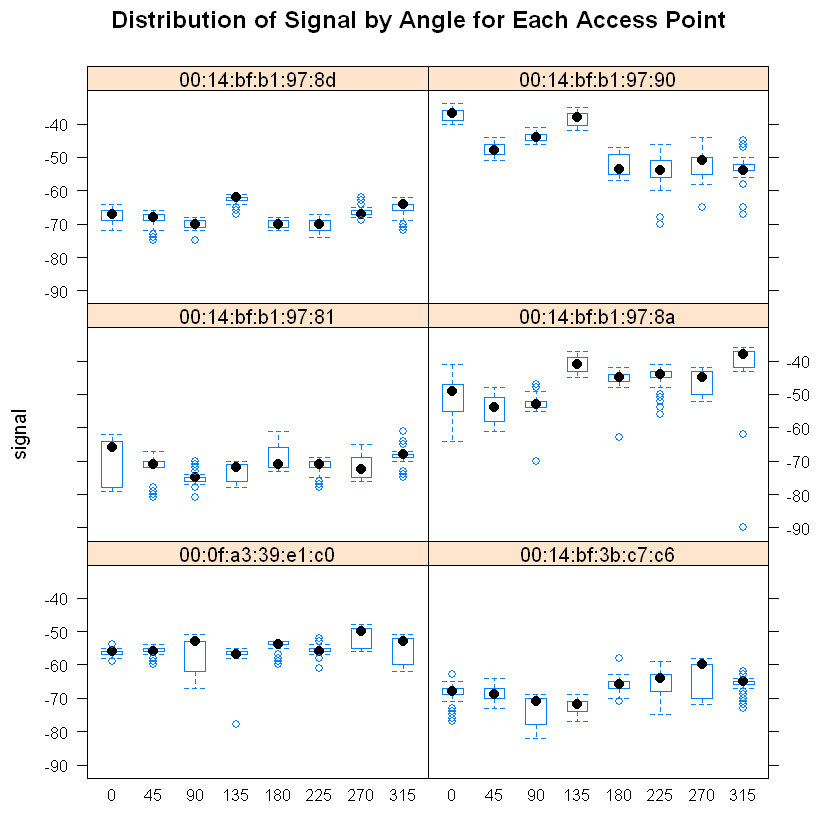

In [10]:
# Signal Strength Analysis excluding mac 00:0f:a3:39:dd:cd
print('Below is a distribution of signals by angle for every access point')
bwplot(signal ~ factor(angle) | mac, data = offlineStage,
       subset = posX == 2 & posY == 12
       & mac != "00:0f:a3:39:dd:cd",
       main = "Distribution of Signal by Angle for Each Access Point",
       layout = c(2,3))


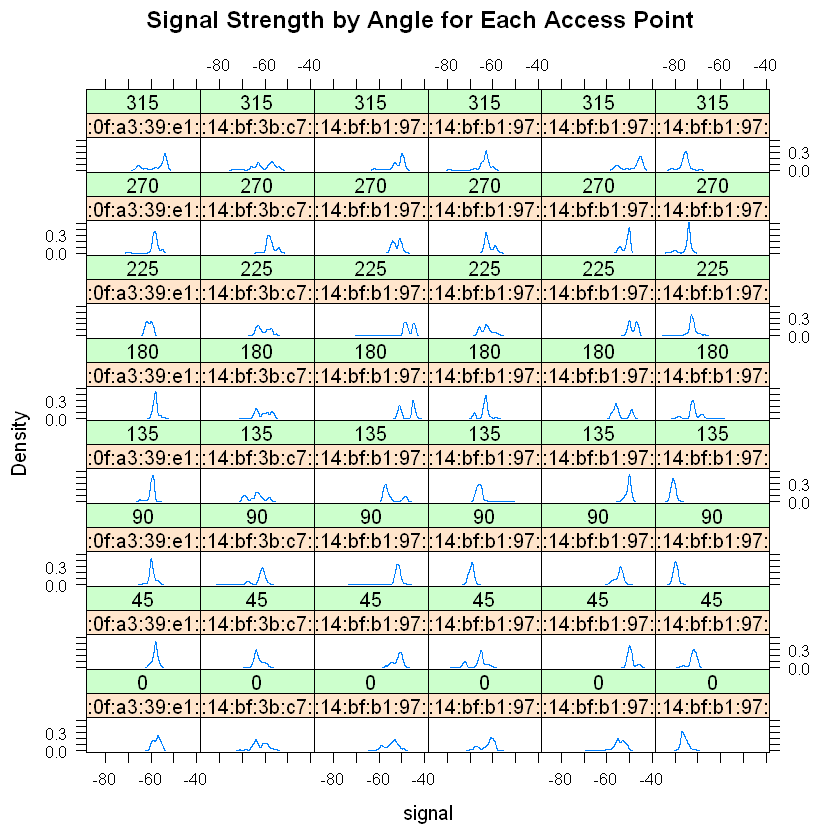

In [11]:
# Density Analysis excluding mac 00:0f:a3:39:dd:cd
densityplot( ~ signal | mac + factor(angle), data = offlineStage,
             subset = posX == 24 & posY == 4 &
             mac != "00:0f:a3:39:dd:cd",
             main = "Signal Strength by Angle for Each Access Point",
             bw = 0.5, plot.points = FALSE)

In [12]:
# Distribution of Signal Strength
offlineStage$posXY = paste(offlineStage$posX, offlineStage$posY, sep = "-")

byLocAngleAP = with(offlineStage,
                    by(offlineStage, list(posXY, angle, mac),
                       function(x) x))
                       
# Adding in additional Signal stats as columns
signalSummary =
  lapply(byLocAngleAP,
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
         })

offlineSummary = do.call("rbind", signalSummary)
breaks = seq(-90, -30, by = 5)


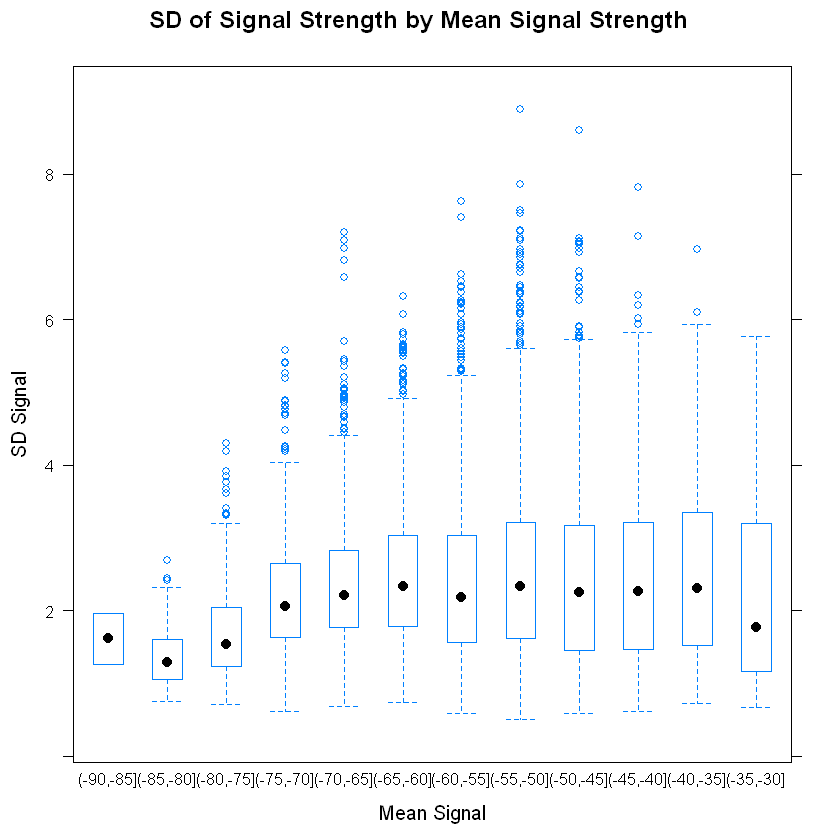

In [13]:
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary,
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", 
       ylab = "SD Signal",
       main = "SD of Signal Strength by Mean Signal Strength")

### OFFLINE DATA - Load, Analyze, Clean and Transform for modeling

In [14]:
# Create function readData() to read the data, cleanse, format and retain required variables
readData =
  function(filename = 'Data/offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp),
                            stringsAsFactors= FALSE)
    names(offline) = c("time", "scanMac",
                       "posX", "posY", "posZ", "orientation",
                       "mac", "signal", "channel", "type")
    # Retain signals from access points
    offline = offline[ offline$type == "3", ]
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    # drop unnecessary access points
    offline = offline[ offline$mac %in% subMacs, ]
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)    
    # convert time to POSIX class
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
    return(offline)
  }

# Create a function to process the data by line/row/record  
# the if statement handles null values to avoid warnings in "R"
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  if (length(tokens) == 10)
    return(NULL)
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6,
               byrow = TRUE), tmp)
}

# create a function that will round off to the nearest major angle
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

#read the data file
offline = readData()

#Setup all the data using the data summary
offline$posXY = paste(offline$posX, offline$posY, sep = "-")
byLocAngleAP = with(offline,
                    by(offline, list(posXY, angle, mac),
                       function(x) x))
signalSummary =
  lapply(byLocAngleAP,
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           11
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
         })

#concatenate rows
offlineSummary = do.call("rbind", signalSummary)

#create vector of all MACS
subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
            "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
            "00:14:bf:b1:97:81")

#create new variable that holds length of the MAC number
mac_number=length(subMacs)

### Preparing the TEST data (online data) - Load, Analyze, Clean, Transform for modeling

In [15]:
# Get the unique macs from the offline data
macs = unique(offlineSummary$mac)

# Read the online data
online = readData("online.final.trace.txt", subMacs = macs)

# create a unique location identifier column posXY by concatenating posX and posY
online$posXY = paste(online$posX, online$posY, sep = "-")

# check the unique values of posXY (test locations) in the data
# length(unique(online$posXY))

# tally the number of signal strengths recorded at each location
tabonlineXYA = table(online$posXY, online$angle) # pivot variables posXY and angle

# check the data
tabonlineXYA[1:6, ] # review the top 6 rows
print('In reviewing the online data set, we can see that there are no signal readings for some angles')

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 704   0   0   0   0
  0.15-9.42    0   0 717   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 684   0   0
  0.47-8.2   701   0   0   0   0   0   0   0
  0.78-10.94 695   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 691   0   0   0

[1] "In reviewing the online data set, we can see that there are no signal readings for some angles"


In [16]:
# Variables to keep
keepVars = c("posXY", "posX","posY", "orientation", "angle")

# create a function to transpose the data
byLoc = with(online,
             by(online, list(posXY),
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = mac_number, dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

# Run the function byLoc and bind as rows
onlineSummary = do.call("rbind", byLoc)

# data is now transformed to new structure with macs in headers
print('The onlineSummary data now consists of the following columns')
head(onlineSummary)

# write.csv(data.frame(onlineSummary),"onlinecsv.txt", row.names = TRUE)

# new variable holds the maximum column number, 12 - all Macs, 11 - other 2 cases
max_col=ncol(onlineSummary)

# new data frame should have 60 rows and 11 variables, 
# including 6 average signal strengths at the corresponding MAC addresses
# dim(onlineSummary)
#names(onlineSummary)
# new variable holds the angles number through the analysis
numAngles=3

[1] "The onlineSummary data now consists of the following columns"


,posXY,posX,posY,orientation,angle,00:0f:a3:39:dd:cd,00:0f:a3:39:e1:c0,00:14:bf:3b:c7:c6,00:14:bf:b1:97:81,00:14:bf:b1:97:8a,00:14:bf:b1:97:8d,00:14:bf:b1:97:90
0-0.05,0-0.05,0.00,0.05,130.5,135,-63,-52,-63,-62,-40,-63,-55
0.15-9.42,0.15-9.42,0.15,9.42,112.3,90,-66,-55,-74,-73,-48,-69,-47
0.31-11.09,0.31-11.09,0.31,11.09,230.1,225,-67,-52,-70,-70,-54,-69,-54
0.47-8.2,0.47-8.2,0.47,8.20,5.8,0,-74,-50,-64,-73,-46,-61,-50
0.78-10.94,0.78-10.94,0.78,10.94,348.3,0,-71,-53,-67,-67,-48,-65,-55
0.93-11.69,0.93-11.69,0.93,11.69,158.3,180,-70,-58,-70,-71,-44,-66,-47


### Choice of Orientation
#### In our nearest neighbor model, we want to find records in our offline data, that have similar orientations to our new observation as orientation can impact strength of signal

In [17]:
# create data frame and functions to aggregate/select data with similar angles
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length = 8)
nearestAngle = roundOrientation(angleNewObs)
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1)
    angles = angles[ -1 ]
  else
    angles = angles[ -m ]
}
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

# After we have the subset of the desired angles, we select the observations to analyze
offlineSubset = offlineSummary[ offlineSummary$angle %in% angles, ]

# Review the unique angles that exist in offlineSubset
# unique(offlineSubset$angle)

# transpose offline data, take a signal mean and reshape
reshapeSS = function(data, varSignal = "signal",
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY),
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = mac_number,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))
  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

# Set offline data as trainSS
trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

# The selectTrain() function averages the signal strengths for the different angles to produce
# one set of signal strengths for each of the 166 locations in the training data
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length = 8)
  nearestAngle = roundOrientation(angleNewObs)
  if (m %% 2 == 1)
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1)
      angles = angles[ -1 ]
  else
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles)
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

### Finding the Nearest Neighbors
##### We have the training data to predict the location of our new point. We need to look at the distance in terms of signal strengths from the training data to the new point. Whether we want 1 nearest neighbor or 3 nearest neighbors we need to calculate the distance from the new point to all observations in the training set.

In [18]:
# Create NN function for simple average
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:(max_col-2)], 1,
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

# Create NNW function for weighted average
findNNW = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:(max_col-2)], 1,
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)))
  closest = order(dists) # order by distance
  closeXY = trainSubset[closest, 1:3 ] # Position index
  weight1d = as.numeric(1/dists[closest]) # With weight calculation 1/distance
  return(cbind(closeXY, weight1d))
}

# the function predXY returns the locations of the training observations 
# in order of closeness to the new observation’s signal strength
# predict X-Y using a Simple Average based on the nearest k neighbors (using default k=3)
predXY = function(newSignals, newAngles, trainData,
                  numAngles = 1, k = 3){
  closeXY = list(length = nrow(newSignals)) # closeXY contains the x and y values returned from findNN()
  for (i in 1:nrow(newSignals)) {
                  trainSS = selectTrain(newAngles[i], trainData, m = numAngles)# get all data matches for the angles
                  closeXY[[i]] =
                  findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
                }
 estXY = lapply(closeXY, # we estimate the location of the new observation with
 function(x) sapply(x[ , 2:3],
                    function(x) mean(x[1:k])))#average of k locations
 estXY = do.call("rbind", estXY)
 return(estXY)
}

# we can use weights in the average that are inversely proportional to the 
# distance (in signal strength) from the test observation
# predict X-Y using a Weighted Average based on the the nearest k neighbors (using default k=3)
predXYW = function(newSignals, newAngles, trainData,
                   numAngles = 1, k = 3){
  closeXY = list(length = nrow(newSignals))
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    weight1d =
      findNNW(newSignal = as.numeric(newSignals[i, ]), trainSS)
    weight = weight1d[1:k, 4]/sum(weight1d[1:k, 4])
    weight= append(weight,replicate( nrow(weight1d)-k, 0)) # add zeros to more than k members
    weight1d[ , 2:3] = weight1d[ , 2:3] * weight # multiply position by weight
    closeXY[[i]] = weight1d[ ,1:3]
  }
  estXY = lapply(closeXY,
                 function(x) sapply(x[ , 2:3],
                                    function(x) sum(x)))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

----------------------------------------------------------------------------------------------------------------------------
# Cross-Validation to obtain optimal k using:

## KNN Simple Average Model
####        1. With all MAC addresses
####        2. Excluding MAC 00:0f:a3:39:dd:cd
####        3. Excluding MAC 00:0f:a3:39:e1:c0

## KNN Weighted Average Model
####       1. With all MAC addresses
####       2. Excluding MAC 00:0f:a3:39:dd:cd
####       3. Excluding MAC 00:0f:a3:39:e1:c0
----------------------------------------------------------------------------------------------------------------------------

## KNN Simple Average Model using all MAC addresses
#### We calculate the error with nearest 1 neighbor, nearest 3 neighbors and then obtain the optimal "k" and calculate the least error

[1] "Using KNN Simple Average with all MACs, the SSE for 1 neighbor is: 478.64"
[1] "Using KNN Simple Average with all MACs, the SSE for 3 neighbors is: 249.427"
[1] "Using KNN Simple Average with all MACs, the optimal k is: 8"
[1] "Using KNN Simple Average with all MACs and optimal k, the least SSE is: 221.74"


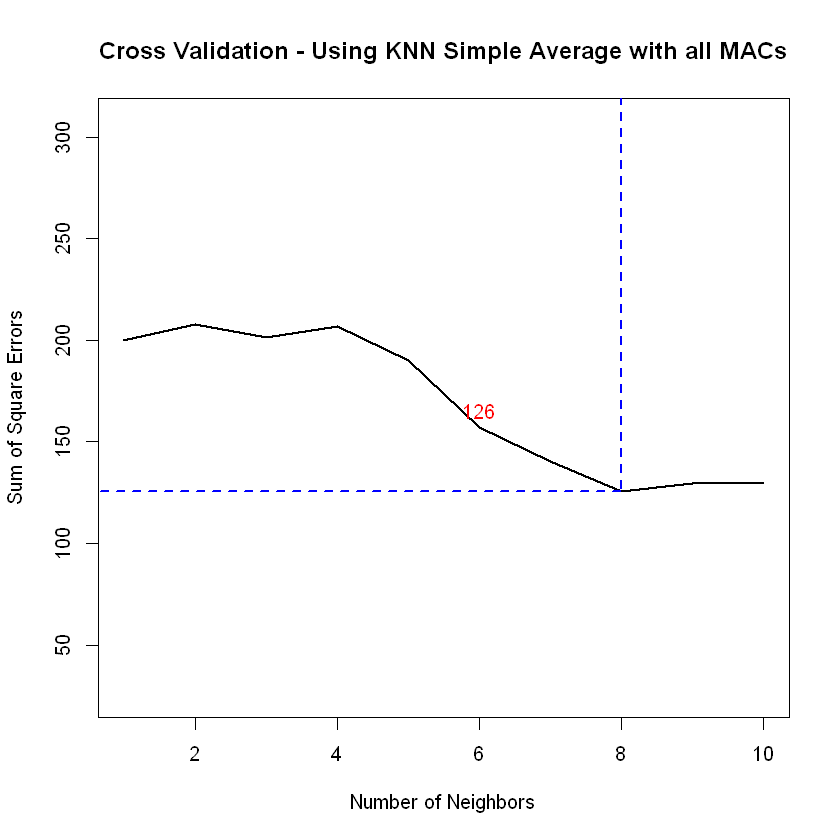

In [19]:
# calculation of nearest 1 neighbor using Simple Average and the onlineSummary test data
estXYk1 = predXY(newSignals = onlineSummary[ , 6:max_col],
                 newAngles = onlineSummary[ , 4],
                 offlineSummary, 
                 numAngles = numAngles, 
                 k = 1)

# calculation of nearest 3 neighbors using Simple Average and the onlineSummary test data
estXYk3 = predXY(newSignals = onlineSummary[ , 6:max_col],
                 newAngles = onlineSummary[ , 4],
                 offlineSummary, 
                 numAngles = numAngles,
                 k = 3)

# Sum of Squared Errors (SSE) calculation
calcError = function(estXY, actualXY) {
              #show(estXY ) -- uncomment for verbose mode
              #show(actualXY) -- uncomment for verbose mode
              return (sum( rowSums( (estXY - actualXY)^2) ))
            }
# apply the calcError function for k=1 and k=3 neighbors
actualXY = onlineSummary[ , c("posX", "posY")]
print(paste(
  'Using KNN Simple Average with all MACs, the SSE for 1 neighbor is:', 
    signif(sapply(list(estXYk1), calcError, actualXY) )),digits = 5)

print(paste(
  'Using KNN Simple Average with all MACs, the SSE for 3 neighbors is:', 
    signif(sapply(list(estXYk3), calcError, actualXY) )),digits = 5)
                                    
# plot the sum of squared errors as a function of k
plot(y = err, 
     x = (1:K), 
     type = "l", 
     lwd= 2,
     ylim = c(min(err)-100, max(err)+100),
     main = "Cross Validation - Using KNN Simple Average with all MACs",
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")
rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, 
         x1 = kMin, 
         y0 = rmseMin, 
         col = "blue",
         lty = 2, 
         lwd = 2)
segments(x0 = kMin, 
         x1 = kMin, 
         y0 = 1100, 
         y1 = rmseMin,
         col = "blue",
         lty = 2, 
         lwd = 2)
text(x = kMin - 2, y = rmseMin + 40,
     label = as.character(round(rmseMin)), col = "red")

# All MACs Optimal "k"
print(paste('Using KNN Simple Average with all MACs, the optimal k is:',kMin))

# Error calculation for Simple average with optimal k
estXYk_best = predXY(newSignals = onlineSummary[ , 6:max_col],
                     newAngles = onlineSummary[ , 4],
                     offlineSummary, numAngles = numAngles, k = kMin)
allMac_SimpleAvg_Best=calcError(estXYk_best, actualXY)

# all MAC Simple Average Estimated Error using optimal kmin
# allMac_SimpleAvg_Best
print(paste('Using KNN Simple Average with all MACs and optimal k, the least SSE is:',
            signif(allMac_SimpleAvg_Best,digits = 5)))

## KNN Weighted Average Model using all MAC addresses
#### We calculate the error with nearest 1 neighbor, nearest 3 neighbors and then obtain the optimal "k" and calculate the least error

[1] "Using KNN Weighted Average with all MACs, the SSE for 1 neighbor is:  478.64"
[1] "Using KNN Weighted Average with all MACs, the SSE for 3 neighbors is:  249.972"
[1] "Using KNN Weighted Average with all MACs, the optimal k :  8"
[1] "Using KNN Weighted Average with all MACs and optimal k, the least SSE is:  214.86"


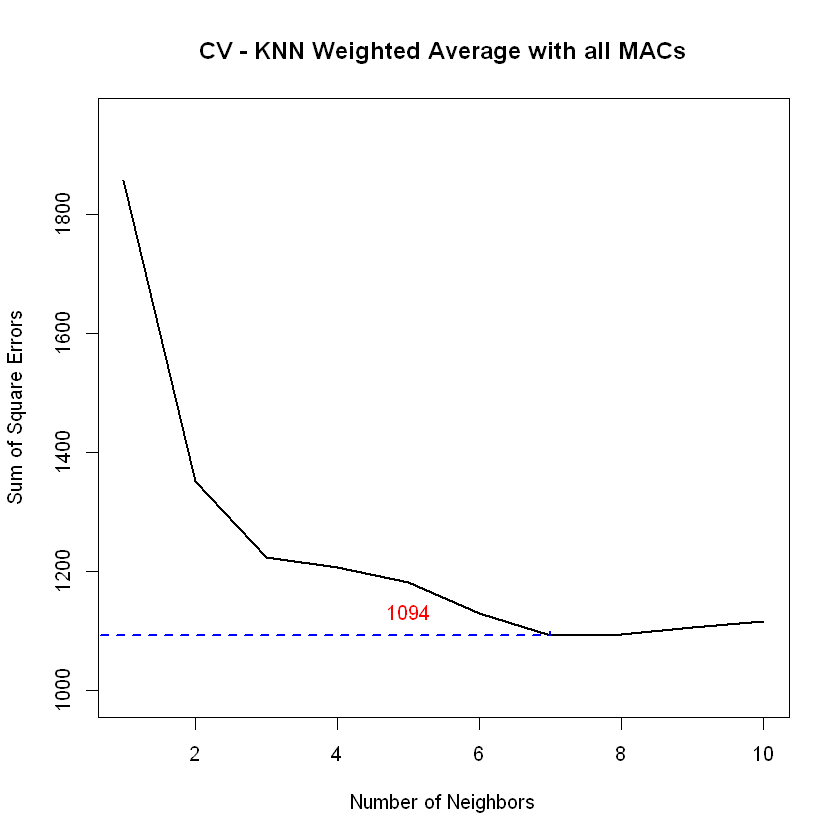

In [20]:
# Error calculation of nearest 1 neighbor using Weighted Average
estXYk1 = predXYW(newSignals = onlineSummary[ , 6:max_col],
                  newAngles = onlineSummary[ , 4],
                  offlineSummary, 
                  numAngles = numAngles, 
                  k = 1)

# Error calculation of nearest 3 neighbors using Weighted Average
estXYk3 = predXYW(newSignals = onlineSummary[ , 6:max_col],
                  newAngles = onlineSummary[ , 4],
                  offlineSummary, 
                  numAngles = numAngles, 
                  k = 3)

# Error calculation for 1 and 3 neighbors using Weighted Average
calcError =
  function(estXY, actualXY) {
    return (sum( rowSums( (estXY - actualXY)^2) ))
  }
# apply the calcError function to our two sets of errors
actualXY = onlineSummary[ , c("posX", "posY")]
print(paste(
  'Using KNN Weighted Average with all MACs, the SSE for 1 neighbor is: ',
        signif(sapply(list(estXYk1), calcError, actualXY) )),digits = 5)

print(paste(
  'Using KNN Weighted Average with all MACs, the SSE for 3 neighbors is: ',
        signif(sapply(list(estXYk3), calcError, actualXY) )),digits = 5)

# ALL MACs - Weighted Average
K = 10
err = rep(0, K)
for (j in 1:v) {
  onlineFold = subset(onlineCVSummary,
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  for (k in 1:K) {
    estFold = predXYW(newSignals = onlineFold[ , 6:max_col],
                      newAngles = onlineFold[ , 4],
                      offlineFold, numAngles = numAngles, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}
# ALL MACs - Weighted Average optimal k
print(paste('Using KNN Weighted Average with all MACs, the optimal k : ',kMin))

#Plot CV result using all MACs with Weighted Average
plot(y = err, x = (1:K), type = "l", lwd= 2,
     ylim = c(min(err)-100, max(err)+100),
     main = "CV - KNN Weighted Average with all MACs",
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")
rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = "blue",
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100, y1 = rmseMin,
         col = "blue", lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40,
     label = as.character(round(rmseMin)), col = "red")

# Error calculation with Weighted Average
estXYk_best = predXYW(newSignals = onlineSummary[ , 6:max_col],
                      newAngles = onlineSummary[ , 4],
                      offlineSummary, numAngles = numAngles, k = kMin)
allMac_WeightedAvg_Best=calcError(estXYk_best, actualXY)

# all MAC Weighted Average Estimated Error using optimal k
print(paste('Using KNN Weighted Average with all MACs and optimal k, the least SSE is: ',
            signif(allMac_WeightedAvg_Best,digits = 5)))

## KNN Simple Average Model excluding MAC: 00:0f:a3:39:dd:cd
#### We calculate the error with nearest 1 neighbor, nearest 3 neighbors and then obtain the optimal "k" and calculate the least error

[1] "Using KNN Simple Average excluding MAC 00:0f:a3:39:dd:cd, the SSE for 1 neighbor is:  659.4"
[1] "Using KNN Simple Average excluding MAC 00:0f:a3:39:dd:cd, the SSE for 3 neighbors is:  306.703"
[1] "Using KNN Simple Average excluding MAC 00:0f:a3:39:dd:cd, the optimal k is:  6"
[1] "Using KNN Simple Average excluding MAC 00:0f:a3:39:dd:cd and optimal k, the least SSE is:  272.41"


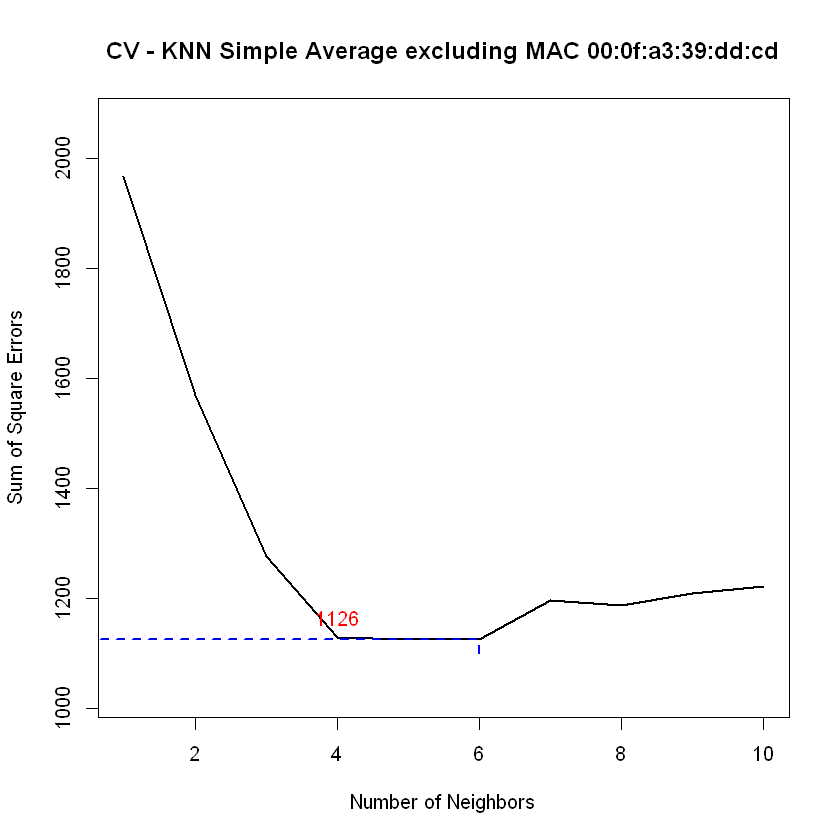

In [21]:
# Keep 00:0f:a3:39:e1:c0 and  exclude 00:0f:a3:39:dd:cd
# making a copy of offlineSummary if required for later use
offlineSummary_copy=offlineSummary

subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
            "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
            "00:14:bf:b1:97:81")

# Exclude MAC 00:0f:a3:39:dd:cd from the data
offlineSummary = subset(offlineSummary_copy, mac !=subMacs[2])
mac_number = length(unique(offlineSummary$mac))

# signal strength matching offline table
macs = unique(offlineSummary$mac)
online = readData("online.final.trace.txt", subMacs = macs)
online$posXY = paste(online$posX, online$posY, sep = "-")
tabonlineXYA = table(online$posXY, online$angle)

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online,
             by(online, list(posXY),
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  #print(avgSS)
                  y = matrix(avgSS, nrow = 1, ncol = mac_number,
                             dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))
onlineSummary = do.call("rbind", byLoc)

#create new variable that holds maximum number of columns
max_col=ncol(onlineSummary)

# Error calculation 1 and 3 neighbors - Simple Average
estXYk3 = predXY(newSignals = onlineSummary[ , 6:max_col],
                 newAngles = onlineSummary[ , 4],
                 offlineSummary, numAngles = numAngles, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:max_col],
                 newAngles = onlineSummary[ , 4],
                 offlineSummary, numAngles = numAngles, k = 1)
calcError =
  function(estXY, actualXY)
    sum( rowSums( (estXY - actualXY)^2) )
actualXY = onlineSummary[ , c("posX", "posY")]
# sapply(list(estXYk1, estXYk3), calcError, actualXY)  
print(paste(
  'Using KNN Simple Average excluding MAC 00:0f:a3:39:dd:cd, the SSE for 1 neighbor is: ',
            signif(sapply(list(estXYk1), calcError, actualXY) )),digits = 5)
print(paste(
  'Using KNN Simple Average excluding MAC 00:0f:a3:39:dd:cd, the SSE for 3 neighbors is: ',
            signif(sapply(list(estXYk3), calcError, actualXY) )),digits = 5)

# Fold creation up to 10 neighbors, 11 folds
offline_copy=offline
offline = offline_copy[ offline_copy$mac != "00:0f:a3:39:dd:cd", ]
keepVars = c("posXY", "posX","posY", "orientation", "angle")
onlineCVSummary = reshapeSS1(offline, keepVars = keepVars,
                             sampleAngle = TRUE)
onlineFold = subset(onlineCVSummary,
                    posXY %in% permuteLocs[ , 1])
offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])
estFold = predXY(newSignals = onlineFold[ , 6:max_col],
                 newAngles = onlineFold[ , 4],
                 offlineFold, numAngles = numAngles, k = 3)

# CV calculation using Simple Average and excluding MAC: 00:0f:a3:39:dd:cd"
K = 10
err = rep(0, K)
for (j in 1:v) {
  onlineFold = subset(onlineCVSummary,
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:max_col],
                     newAngles = onlineFold[ , 4],
                     offlineFold, numAngles = numAngles, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

# Plot result
plot(y = err, x = (1:K), type = "l", lwd= 2,
     ylim = c(min(err)-100, max(err)+100),
     main = "CV - KNN Simple Average excluding MAC 00:0f:a3:39:dd:cd",
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = "blue",
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100, y1 = rmseMin,
         col = "blue", lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40,
     label = as.character(round(rmseMin)), col = "red")

print(paste('Using KNN Simple Average excluding MAC 00:0f:a3:39:dd:cd, the optimal k is: ',kMin))

# Error calculation using Simple Average and excluding MAC: 00:0f:a3:39:dd:cd"
estXYk_best = predXY(newSignals = onlineSummary[ , 6:max_col],
                     newAngles = onlineSummary[ , 4],
                     offlineSummary, numAngles = numAngles, k = kMin)
no_cd_mac_SimpleAverage_best=calcError(estXYk_best, actualXY)
print(paste('Using KNN Simple Average excluding MAC 00:0f:a3:39:dd:cd and optimal k, the least SSE is: ',
            signif(no_cd_mac_SimpleAverage_best,digits = 5)))

[1] "Using KNN Weighted Average excluding MAC 00:0f:a3:39:dd:cd, the SSE for 1 neighbor is:  659.4"
[1] "Using KNN Weighted Average excluding MAC 00:0f:a3:39:dd:cd, the SSE for 3 neighbors is:  302.456"
[1] "Using KNN Weighted Average excluding MAC 00:0f:a3:39:dd:cd, the optimal k is:  6"
[1] "Using KNN Weighted Average excluding MAC 00:0f:a3:39:dd:cd and optimal k, the least SSE is:  271.28"


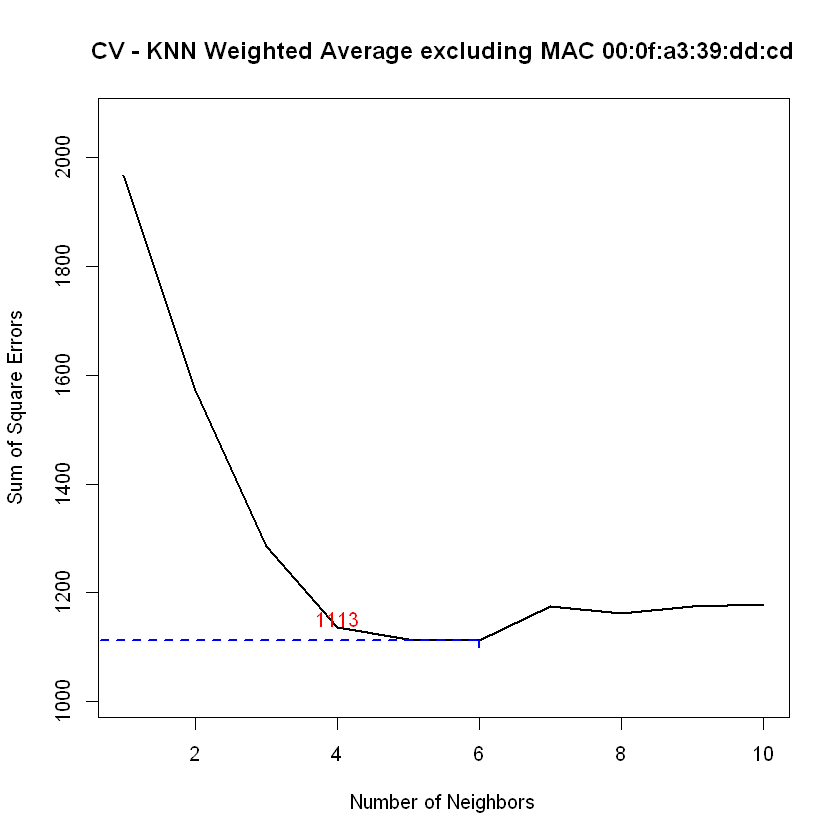

In [22]:
# Error calculation 1 and 3 neighbors - Weighted Average
estXYk3 = predXYW(newSignals = onlineSummary[ , 6:max_col],
                  newAngles = onlineSummary[ , 4],
                  offlineSummary, numAngles = numAngles, k = 3)
estXYk1 = predXYW(newSignals = onlineSummary[ , 6:max_col],
                  newAngles = onlineSummary[ , 4],
                  offlineSummary, numAngles = numAngles, k = 1)
calcError =
  function(estXY, actualXY)
    sum( rowSums( (estXY - actualXY)^2) )
actualXY = onlineSummary[ , c("posX", "posY")]
#sapply(list(estXYk1, estXYk3), calcError, actualXY) 
print(paste(
  'Using KNN Weighted Average excluding MAC 00:0f:a3:39:dd:cd, the SSE for 1 neighbor is: '
  ,signif(sapply(list(estXYk1), calcError, actualXY) )), digits = 5)

print(paste(
  'Using KNN Weighted Average excluding MAC 00:0f:a3:39:dd:cd, the SSE for 3 neighbors is: '
  ,signif(sapply(list(estXYk3), calcError, actualXY) )), digits = 5)

# CV calculation using Weighted Average and excluding MAC: 00:0f:a3:39:dd:cd"
K = 10
err = rep(0, K)
for (j in 1:v) {
  onlineFold = subset(onlineCVSummary,
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  25
  actualFold = onlineFold[ , c("posX", "posY")]
  for (k in 1:K) {
    estFold = predXYW(newSignals = onlineFold[ , 6:max_col],
                      newAngles = onlineFold[ , 4],
                      offlineFold, numAngles = numAngles, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

# Plot result
plot(y = err, x = (1:K), type = "l", lwd= 2,
     ylim = c(min(err)-100, max(err)+100),
     main = "CV - KNN Weighted Average excluding MAC 00:0f:a3:39:dd:cd",
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = "blue",
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100, y1 = rmseMin,
         col = "blue", lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40,
     label = as.character(round(rmseMin)), col = "red")

print(paste('Using KNN Weighted Average excluding MAC 00:0f:a3:39:dd:cd, the optimal k is: ',kMin))

# Error calculation using Weighted Average and excluding MAC: 00:0f:a3:39:dd:cd"
estXYk_best = predXYW(newSignals = onlineSummary[ , 6:max_col],
                      newAngles = onlineSummary[ , 4],
                      offlineSummary, numAngles = numAngles, k = kMin)
no_cd_mac_WeightedAverage_best =calcError(estXYk_best, actualXY)
print(paste('Using KNN Weighted Average excluding MAC 00:0f:a3:39:dd:cd and optimal k, the least SSE is: ',
                                signif(no_cd_mac_WeightedAverage_best, digits = 5)))

## KNN Simple Average Model excluding MAC 00:0f:a3:39:e1:c0
#### We calculate the error with nearest 1 neighbor, nearest 3 neighbors and then obtain the optimal "k" and calculate the least error

[1] "Using KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0, the SSE for 1 neighbor is:  411.64"
[1] "Using KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0, the SSE for 3 neighbors is:  270.458"
[1] "Using KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0, the optimal k is: 6"
[1] "Using KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0 and optimal k, the least SSE is:  252.34"


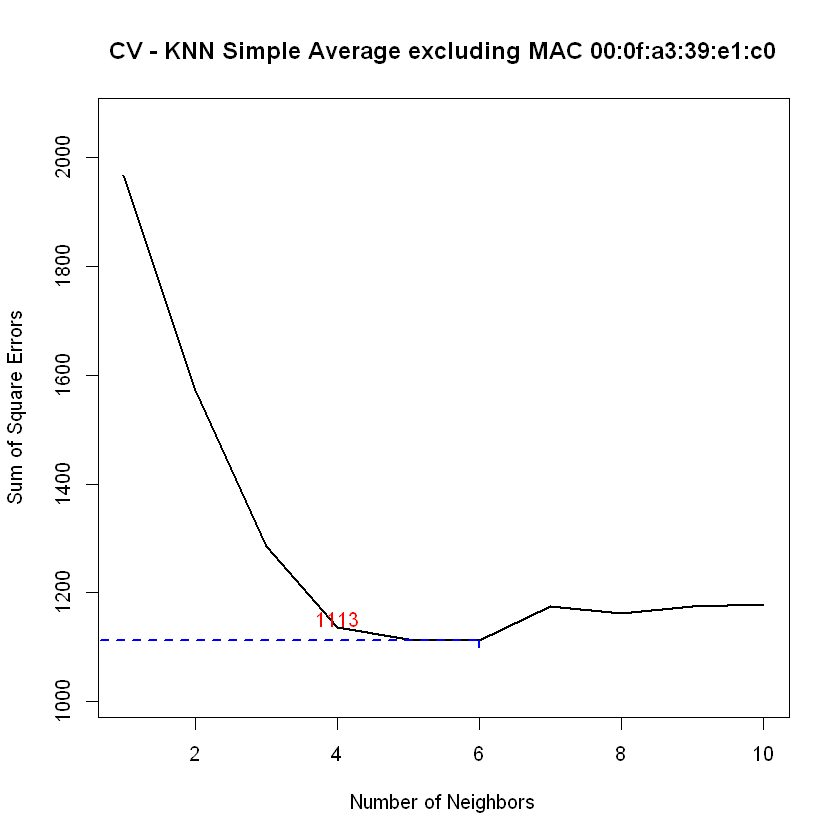

In [23]:
# Keep MAC 00:0f:a3:39:dd:cd ##### remove MAC 00:0f:a3:39:e1:c0
# Copy of offlineSummary for later use
offlineSummary_copy2=offlineSummary
subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
            "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
            "00:14:bf:b1:97:81")

# remove 00:0f:a3:39:e1:c0 MAC
offlineSummary = subset(offlineSummary_copy, mac !=subMacs[1])
mac_number = length(unique(offlineSummary$mac))

# Matching online data with offline
macs = unique(offlineSummary$mac)
online = readData("online.final.trace.txt", subMacs = macs)
online$posXY = paste(online$posX, online$posY, sep = "-")
tabonlineXYA = table(online$posXY, online$angle)
keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online,
             by(online, list(posXY),
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = mac_number,
                             dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)
max_col=ncol(onlineSummary)

#Error calculation using Simple Average excluding MAC 00:0f:a3:39:e1:c0
estXYk3 = predXY(newSignals = onlineSummary[ , 6:max_col],
                 newAngles = onlineSummary[ , 4],
                 offlineSummary, numAngles = numAngles, k = 3)
estXYk1 = predXY(newSignals = onlineSummary[ , 6:max_col],
                 newAngles = onlineSummary[ , 4],
                 offlineSummary, numAngles = numAngles, k = 1)
calcError =
  function(estXY, actualXY)
    sum( rowSums( (estXY - actualXY)^2) )
actualXY = onlineSummary[ , c("posX", "posY")]
#sapply(list(estXYk1, estXYk3), calcError, actualXY)
print(paste(
  'Using KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0, the SSE for 1 neighbor is: '
  ,signif(sapply(list(estXYk1), calcError, actualXY) )),digits = 5)

print(paste(
  'Using KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0, the SSE for 3 neighbors is: '
  ,signif(sapply(list(estXYk3), calcError, actualXY) )),digits = 5)

# estXYk_best = predXY(newSignals = onlineSummary[ , 6:max_col],
#                      newAngles = onlineSummary[ , 4],
#                      offlineSummary, numAngles = numAngles, k = kMin)
# noc0_mac_SimpleAverage_best=calcError(estXYk_best, actualXY)
# print(paste('Using KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0 and optimal k, the least SSE is: ',
#             signif(noc0_mac_SimpleAverage_best,digits = 5)))

# Plot result
plot(y = err, x = (1:K), type = "l", lwd= 2,
     ylim = c(min(err)-100, max(err)+100),
     main = "CV - KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0",
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")
rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = "blue",
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100, y1 = rmseMin,
         col = "blue", lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40,
     label = as.character(round(rmseMin)), col = "red")

print(paste('Using KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0, the optimal k is:',kMin))

estXYk_best = predXY(newSignals = onlineSummary[ , 6:max_col],
                     newAngles = onlineSummary[ , 4],
                     offlineSummary, numAngles = numAngles, k = kMin)
noc0_mac_SimpleAverage_best=calcError(estXYk_best, actualXY)
print(paste('Using KNN Simple Average excluding MAC 00:0f:a3:39:e1:c0 and optimal k, the least SSE is: ',
            signif(noc0_mac_SimpleAverage_best,digits = 5)))

[1] "Using KNN Weighted Average excluding MAC 00:0f:a3:39:e1:c0, the SSE for 1 neighbor is:  411.64"
[1] "Using KNN Weighted Average excluding MAC 00:0f:a3:39:e1:c0, the SSE for 3 neighbors is:  267.112"
[1] "Using KNN Weighted Average excluding MAC 00:0f:a3:39:e1:c0, the optimal k is: 8"
[1] "Using KNN Weighted Average excluding MAC 00:0f:a3:39:e1:c0 and optimal k, the least SSE is:  247.34"


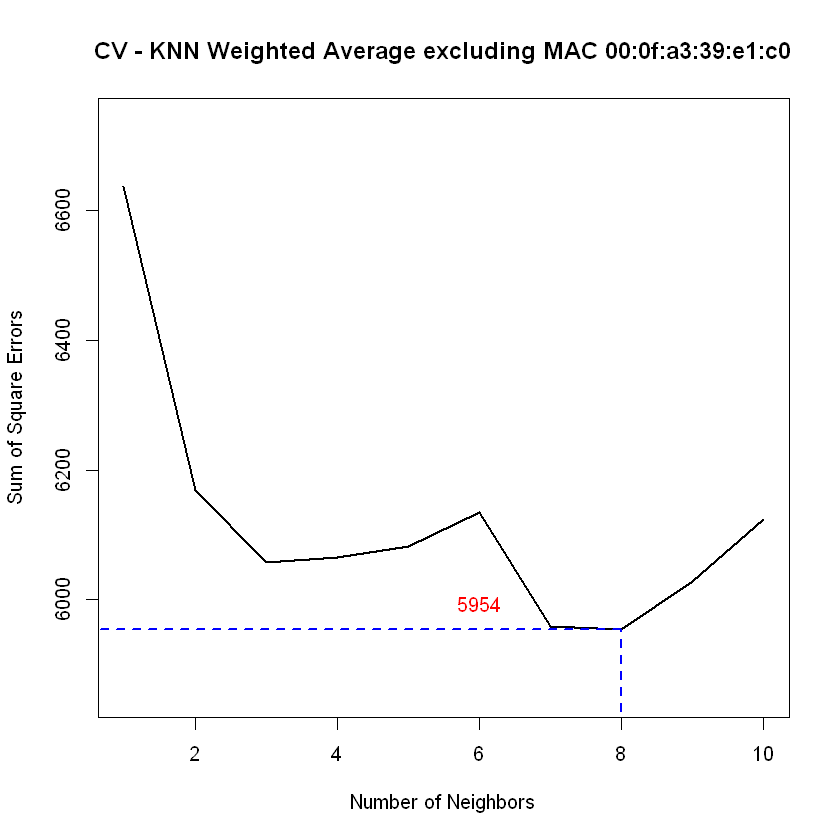

In [24]:
# Error calculation using Weighted Average excluding MAC 00:0f:a3:39:e1:c0
estXYk3 = predXYW(newSignals = onlineSummary[ , 6:max_col],
                  newAngles = onlineSummary[ , 4],
                  offlineSummary, numAngles = numAngles, k = 3)

estXYk1 = predXYW(newSignals = onlineSummary[ , 6:max_col],
                  newAngles = onlineSummary[ , 4],
                  offlineSummary, numAngles = numAngles, k = 1)
calcError =
  function(estXY, actualXY)
    sum( rowSums( (estXY - actualXY)^2) )
actualXY = onlineSummary[ , c("posX", "posY")]
#sapply(list(estXYk1, estXYk3), calcError, actualXY)
print(paste(
  'Using KNN Weighted Average excluding MAC 00:0f:a3:39:e1:c0, the SSE for 1 neighbor is: '
  ,signif(sapply(list(estXYk1), calcError, actualXY) )),digits=5)

print(paste(
  'Using KNN Weighted Average excluding MAC 00:0f:a3:39:e1:c0, the SSE for 3 neighbors is: '
  ,signif(sapply(list(estXYk3), calcError, actualXY) )),digits=5)

# CV calculation adding weight factor
K = 10
err = rep(0, K)
for (j in 1:v) {
  onlineFold = subset(onlineCVSummary,
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  for (k in 1:K) {
    estFold = predXYW(newSignals = onlineFold[ , 6:max_col],
                      newAngles = onlineFold[ , 4],
                      offlineFold, numAngles = numAngles, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

# Plot result
plot(y = err, x = (1:K), type = "l", lwd= 2,
     ylim = c(min(err)-100, max(err)+100),
     main = "CV - KNN Weighted Average excluding MAC 00:0f:a3:39:e1:c0",
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = "blue",
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100, y1 = rmseMin,
         col = "blue", lty = 2, lwd = 2)
text(x = kMin - 2, y = rmseMin + 40,
     label = as.character(round(rmseMin)), col = "red")

print(paste('Using KNN Weighted Average excluding MAC 00:0f:a3:39:e1:c0, the optimal k is:',kMin))

# error calculation with weight factor
estXYk_best = predXYW(newSignals = onlineSummary[ , 6:max_col],
                      newAngles = onlineSummary[ , 4],
                      offlineSummary, numAngles = numAngles, k = kMin)
noc0_mac_weight_best=calcError(estXYk_best, actualXY)
print(paste('Using KNN Weighted Average excluding MAC 00:0f:a3:39:e1:c0 and optimal k, the least SSE is: ',
            signif(noc0_mac_weight_best,digits = 5)))